In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_legacy_without_padding_with_dense import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [22]:

#Define target cleavage loss function
def get_cleavage_loss(cut_pos, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_up_c=0.0, reward_dn_ggcc=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_cuts = np.zeros((1, 1, 186))
    target_cuts[:, :, cut_pos] = 1.0
    
    use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    #use_entropy_mse = get_margin_entropy(pwm_start=use_start, pwm_end=use_end, min_bits=use_target_bits)
    #cse_entropy_mse = get_margin_entropy(pwm_start=cse_start, pwm_end=cse_end, min_bits=cse_target_bits)
    #dse_entropy_mse = get_margin_entropy(pwm_start=dse_start, pwm_end=dse_end, min_bits=dse_target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=0, pwm_end=49)
    
    reward_dn_ggcc_func = get_reward_gg_and_cc(pwm_start=60, pwm_end=90)
    punish_up_aa_func = get_punish_aa(pwm_start=0, pwm_end=49)
    punish_dn_aa_func = get_punish_aa(pwm_start=55, pwm_end=100)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs

        #Create target cut constant
        cut_true = K.tile(K.constant(target_cuts), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, cut_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += reward_dn_ggcc * K.mean(reward_dn_ggcc_func(sampled_pwm), axis=0)
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        #entropy_loss = entropy_weight * target_entropy_mse(pwm) + 0.5 * cse_entropy_mse(pwm)
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, target_cuts, loss_funcs, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        target_cut = target_cuts[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=185, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=22), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=49, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=49-40, pwm_end=55+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts
        


In [14]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_name = 'aparent_theano_legacy_30_31_34.h5'
model_path = os.path.join(save_dir, model_name)

In [15]:
#Define standard sequence template

seq_template = 'ATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT'

#Define list of target cleavage positions

cut_objectives = [60, 65, 70, 75, 80, 85, 90, 95, 100]


Running optimization experiment 'Vanilla'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 149s 75ms/step - loss: 1.5754


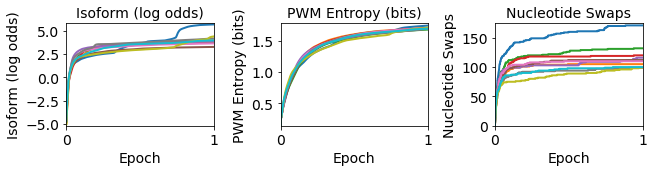

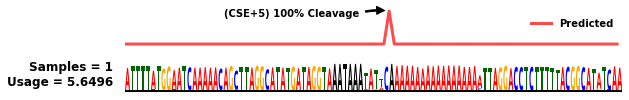

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 158s 79ms/step - loss: 1.0692


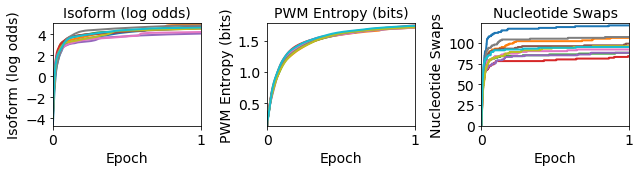

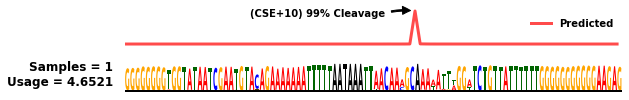

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 159s 80ms/step - loss: 0.9023


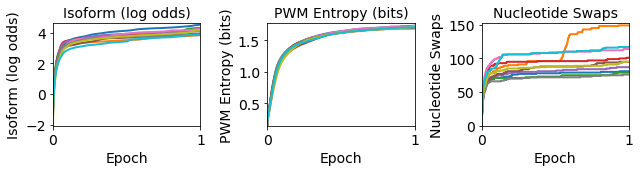

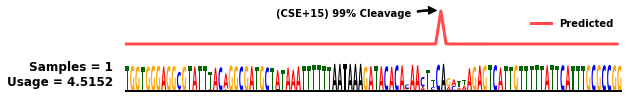

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 140s 70ms/step - loss: 0.9244


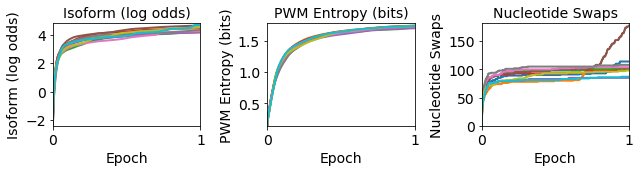

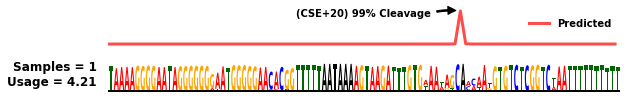

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 0.9953


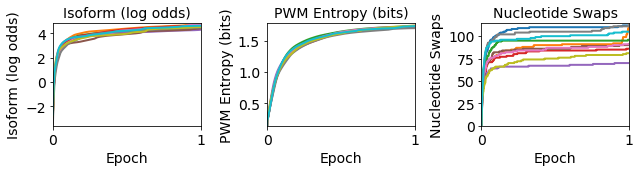

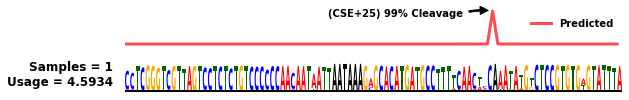

Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 82s 41ms/step - loss: 1.3267


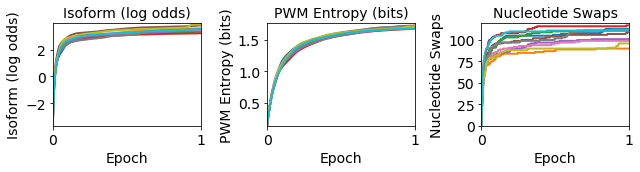

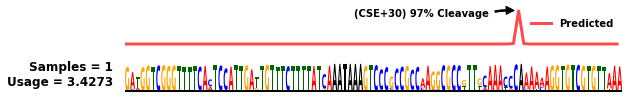

Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 76s 38ms/step - loss: 3.9266


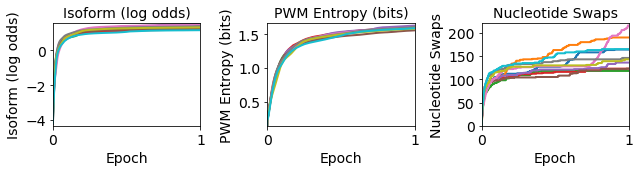

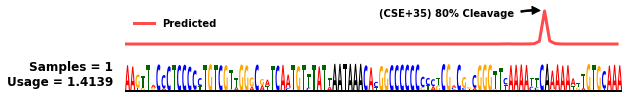

Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 81s 40ms/step - loss: 4.3451


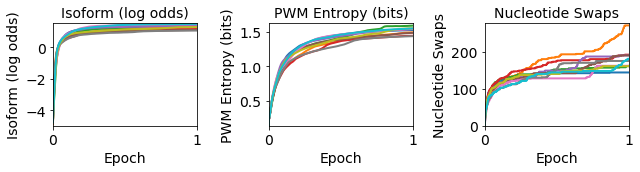

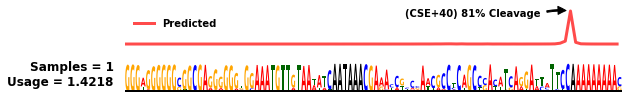

Optimizing objective 8...
Epoch 1/1
2000/2000 [==============================] - 72s 36ms/step - loss: 4.5336


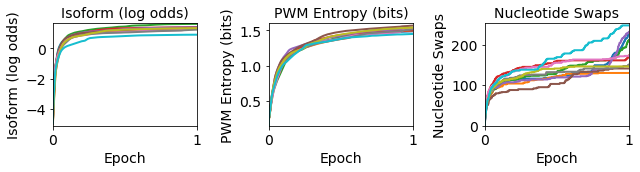

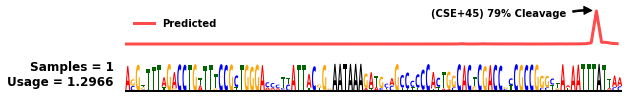

In [18]:
#Run SeqProp Optimization (experiment 'Vanilla')

print("Running optimization experiment 'Vanilla'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        reward_dn_ggcc=0.01 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.0,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

vanilla_pwms, vanilla_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


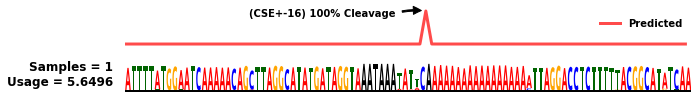

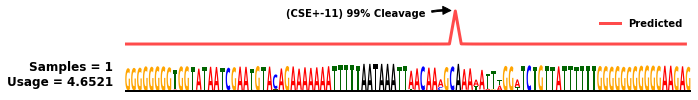

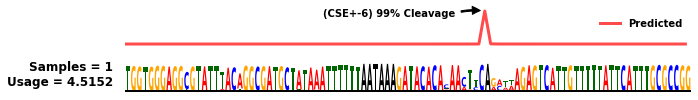

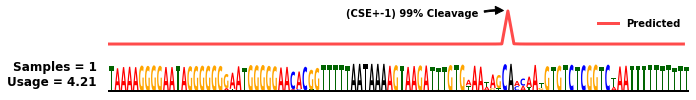

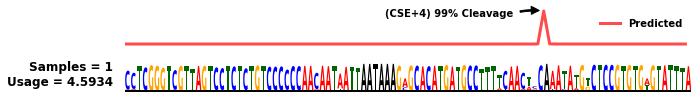

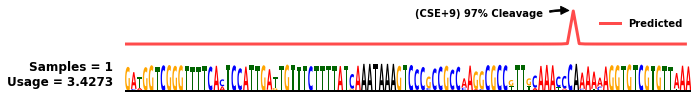

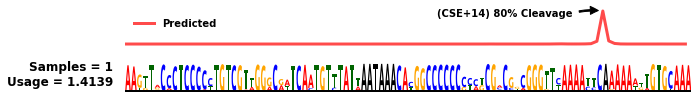

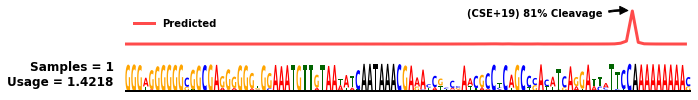

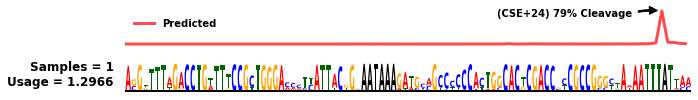

In [20]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Vanilla')

pwms = vanilla_pwms
cuts = vanilla_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'Punish A-runs'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 69s 34ms/step - loss: 3.3059


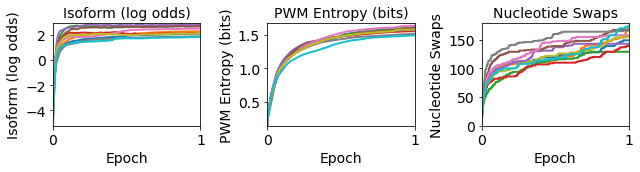

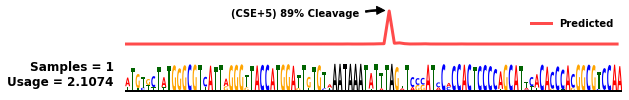

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 67s 34ms/step - loss: 1.7060


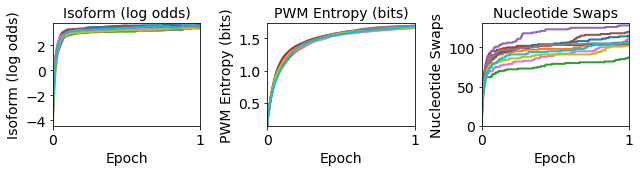

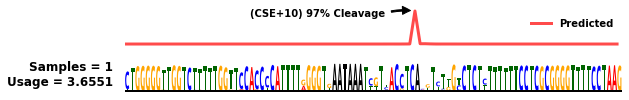

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 73s 36ms/step - loss: 1.0765


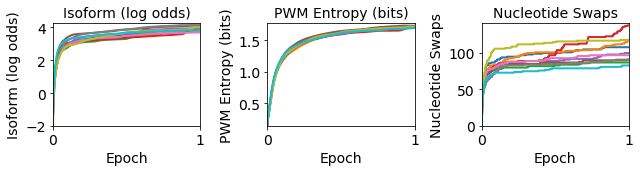

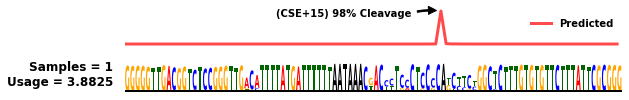

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 74s 37ms/step - loss: 1.1440


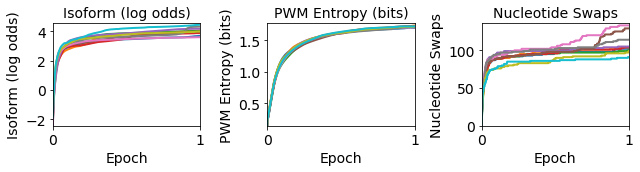

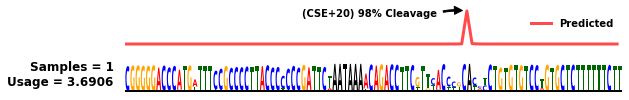

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 1.1942


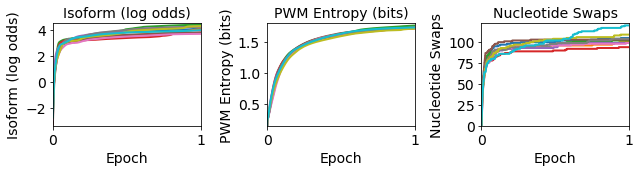

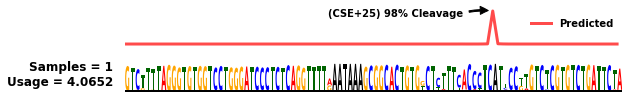

Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 76s 38ms/step - loss: 1.8081


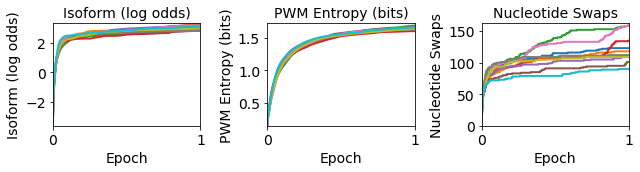

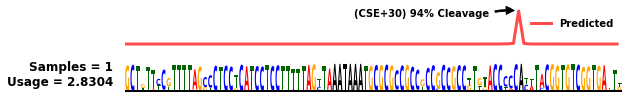

Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 80s 40ms/step - loss: 5.4297


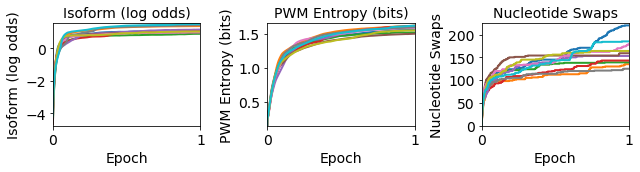

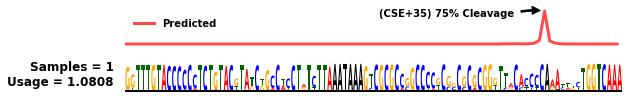

Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 6.8297


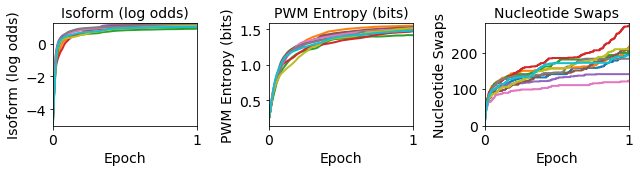

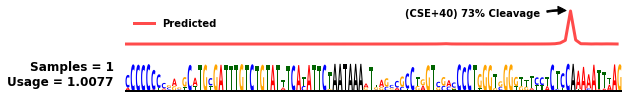

Optimizing objective 8...
Epoch 1/1
2000/2000 [==============================] - 75s 37ms/step - loss: 5.3934


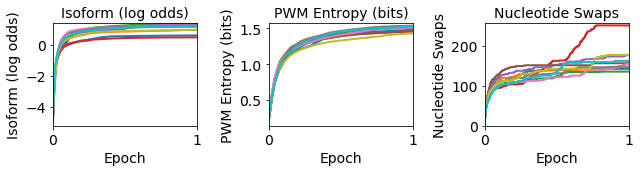

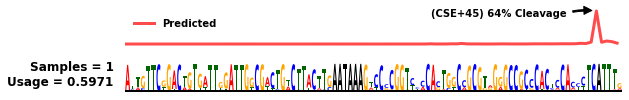

In [23]:
#Run SeqProp Optimization (experiment 'Punish A-runs')

print("Running optimization experiment 'Punish A-runs'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        reward_dn_ggcc=0.05 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.01,
        punish_dn_aa=0.05
    ) for cut_pos in cut_objectives
]

punish_aruns_pwms, punish_aruns_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


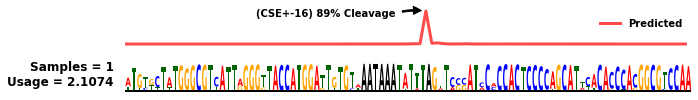

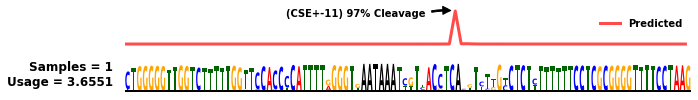

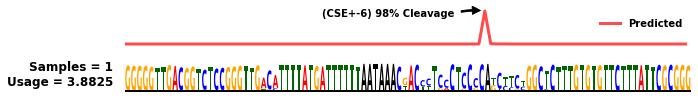

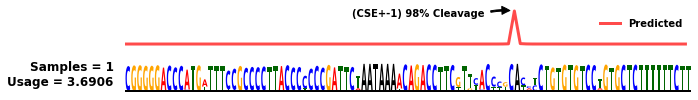

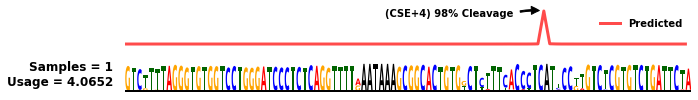

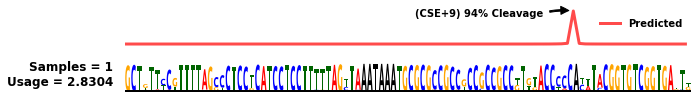

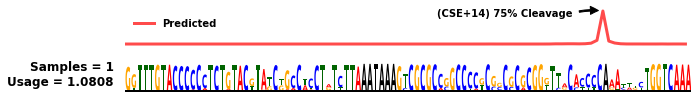

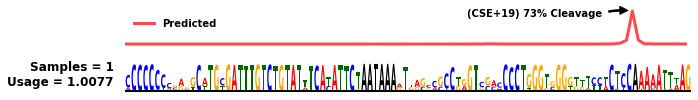

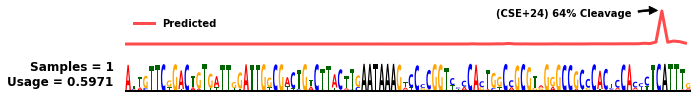

In [25]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

pwms = punish_aruns_pwms
cuts = punish_aruns_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)


In [ ]:
#Run SeqProp Optimization (experiment 'Hardcoded AT')

print("Running optimization experiment 'Hardcoded AT'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "AT" + seq_template[cut_pos + 2:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.001,
        reward_dn_ggcc=0.01 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.0,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

hardcoded_at_pwms, hardcoded_at_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


In [ ]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Hardcoded AT')

pwms = hardcoded_at_pwms
cuts = hardcoded_at_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)
